# Metric Learning Encoding Models
## Walkthrough to use the MLEM pipeline and reproduce the figures from the paper
Paper: https://arxiv.org/abs/2402.11608  
Author: Louis Jalouzot (jalouzot.louis@gmail.com)

## Imports

Import and instantiate the `MLEMPipeline` class and look at some of the default parameters. Most of the results are going to be saved in `work_dir`, consider changing it if it doesn't suit you.  
The default dataset is `short_sentence`. The larger ones `relative_clause`, `long_range_agreement` and `large` are also available. If you want to use your dataset, save it in csv format in `{work_dir}/datasets/{dataset}.csv` without the index column. It should have a column "sentence" holding the sentences on which the language models will be recorded and the other columns will be treated as linguistic features. Beware that the computation times increase quadratically with the size of the dataset.

In [ ]:
%matplotlib inline
from MLEM import *
pipeline = MLEMPipeline()
pipeline

## Dataset

Compute the feature distance matrix once and for all for this dataset.

In [ ]:
pipeline.compute_features_distance()

Check the correlation between the features.

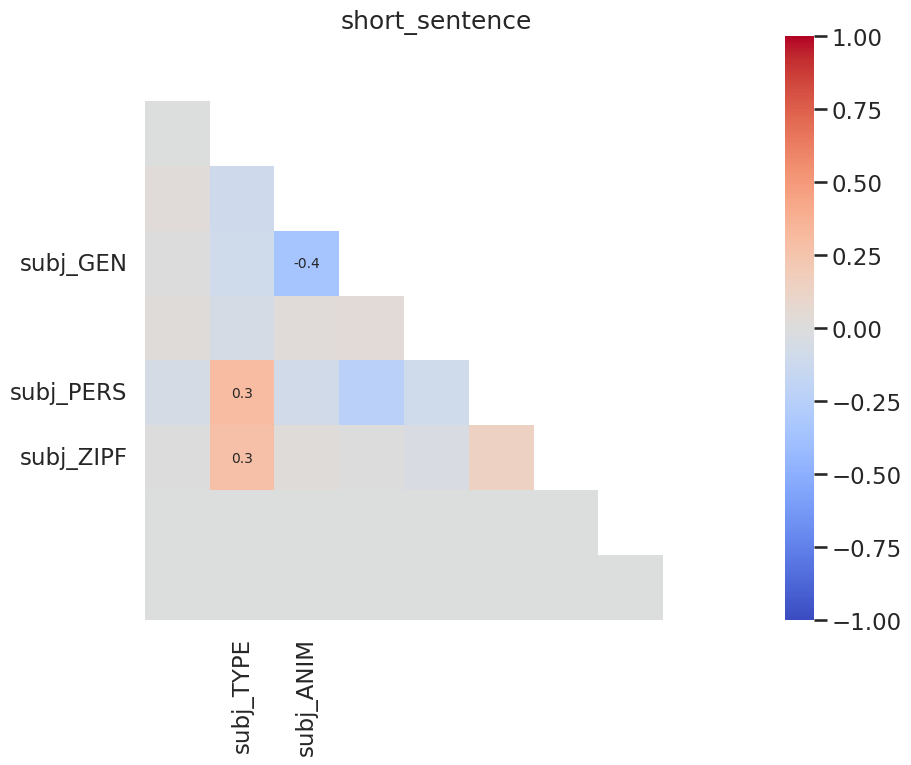

In [3]:
ax = pipeline.plot_correlation(thresh=0.25)

## Multivariate Feature Importance

Compute the feature importance at layer 5 (default) with a high level of verbose. By default Permutation Feature Importance is computed and not Conditional Permutation Feature Importance. You can enable it with `pipeline.conditional = True` however it is more computationally intensive and not usefull for datasets without correlations between the features.

In [ ]:
pipeline.verbose = 2
pipeline.compute_feature_importance()

Compute for the other layers. The default model `bert-base-uncased` has 12 layers.

In [ ]:
pipeline.verbose = 0
for layer in tqdm(range(1, 13)):
    pipeline.layer = layer
    pipeline.compute_feature_importance()

You can visualize those results with `plot_feature_importance` whose parameter `top` (default to 4) determines how many features are displayed.

  0%|          | 0/12 [00:00<?, ?it/s]

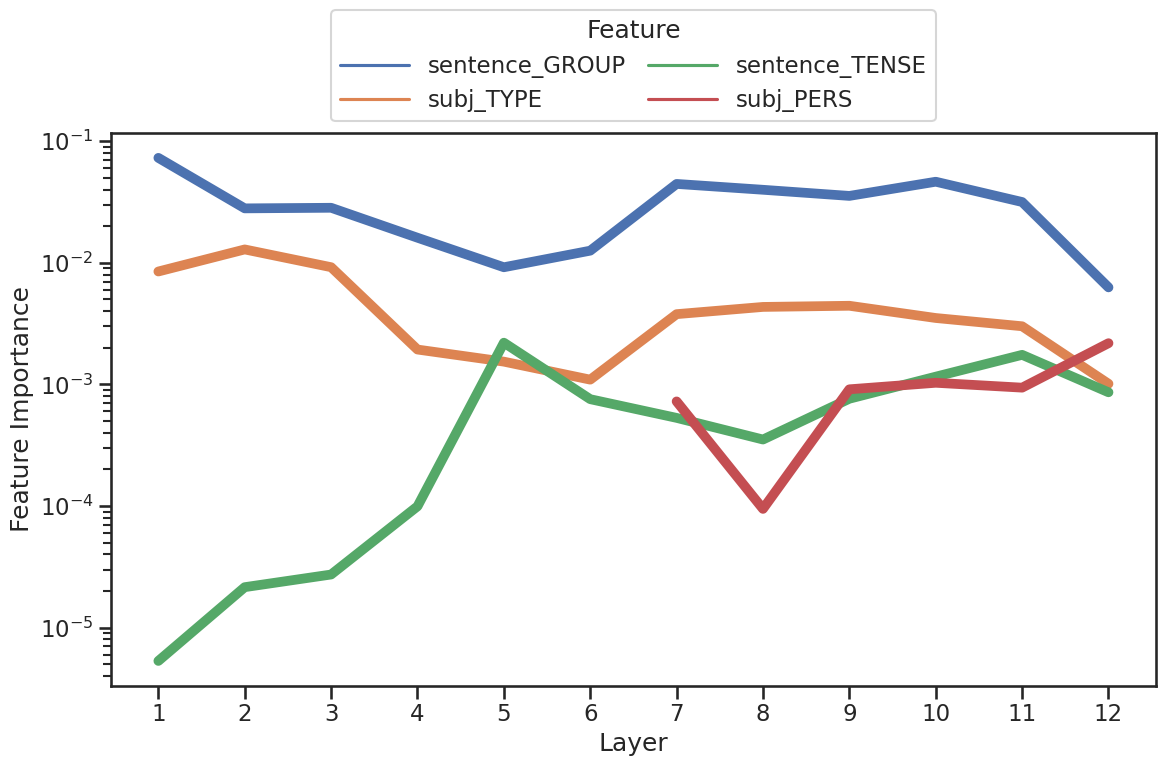

In [6]:
ax = pipeline.plot_feature_importance()

## Decoding baseline

Compute the decoding baseline for some layers.

In [ ]:
for layer in tqdm(range(4, 7)):
    pipeline.layer = layer
    pipeline.compute_decoding_baseline()

Visualize the baseline along with the Feature Importance.

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

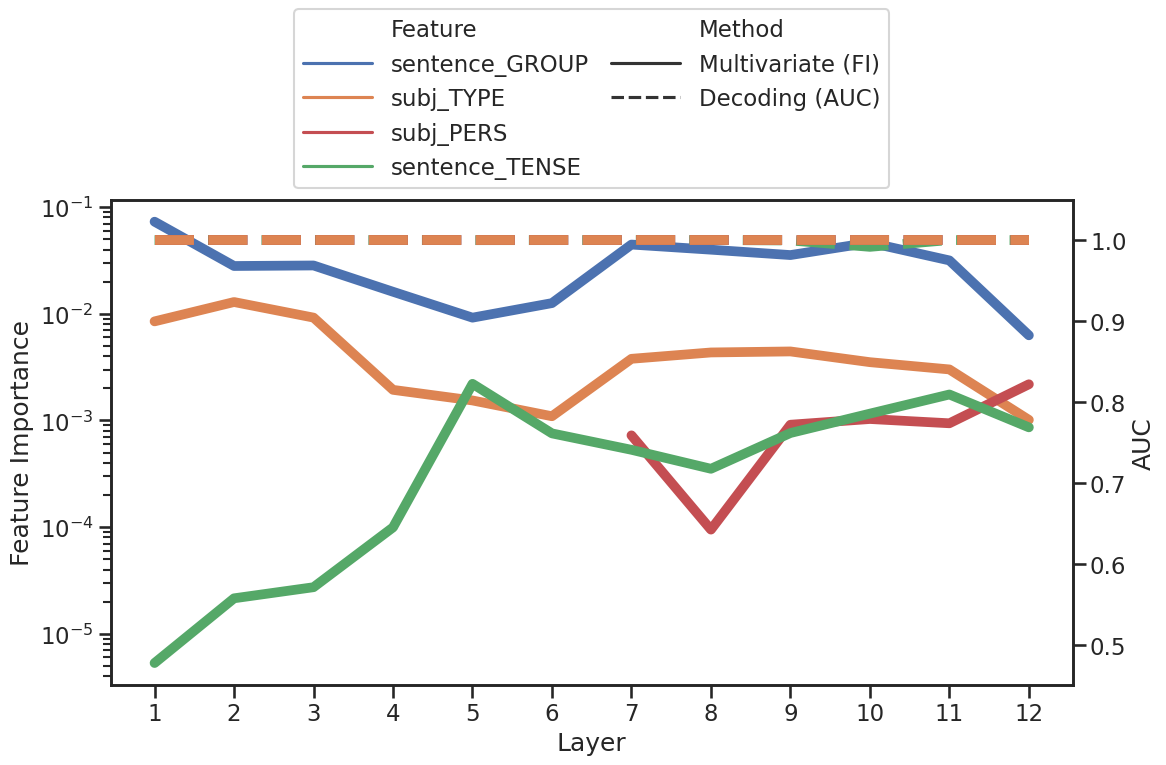

In [8]:
ax = pipeline.plot_feature_importance(decoding=True)

## MDS and hierarchy

To visualize the sentences representations using MDS and highlight the potential hierarchy of features defined by the feature importance, one can use `plot_mds`.  
For instance, still for the `short_sentence` dataset, the Feature Importance shows the order `sentence_GROUP > subj_TYPE > sentence_TENSE` at layer 11 which we can try to visualize.

In [ ]:
pipeline.layer = 11
pipeline.compute_mds()

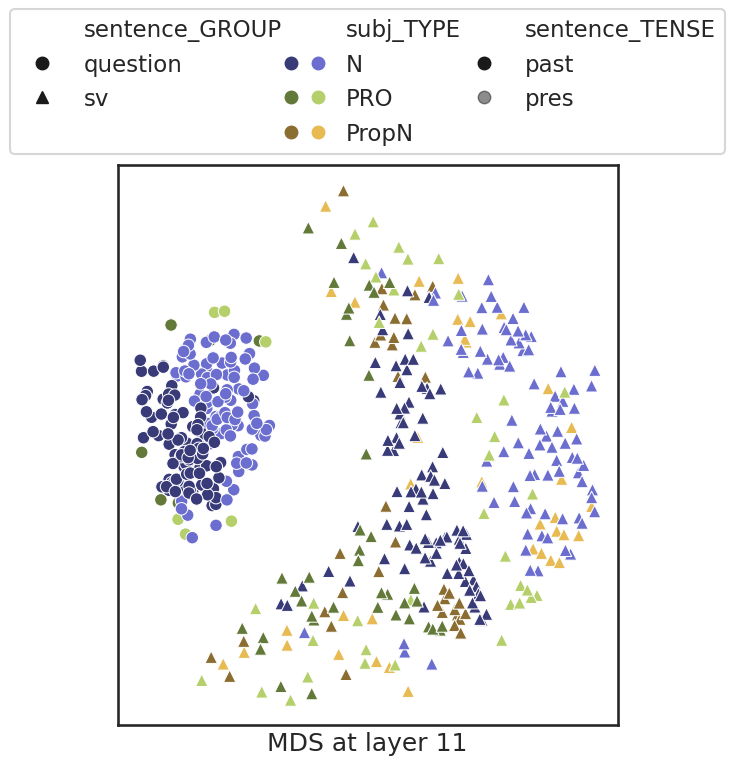

In [11]:
hierarchy = ["sentence_GROUP", "subj_TYPE", "sentence_TENSE"]
ax = pipeline.plot_mds(hierarchy=hierarchy)

One can also load the dataset with the MDS coordinates in the columns "x" and "y" using `get_dataset` as follows

In [ ]:
pipeline.compute_mds()
df_mds = pipeline.get_dataset(mds=True)
df_mds[["sentence", "x", "y"]]

## Univariate Feature Importance

Compute the univariate Feature Importance for all units at layer 5. This method is slow as it requires running the pipeline once per unit.

In [ ]:
pipeline.layer = 5
pipeline.compute_univariate_feature_importance()

Visualize the Feature Importance of the clusters of units at layer 5. The cluster are obtained based on the univariate Feature Importance of the units and using KMeans and the silhouette method to have an optimal number of clusters. A dataframe with all the data can be obtained with the method `cluster_fi`.

  0%|          | 0/12 [00:00<?, ?it/s]

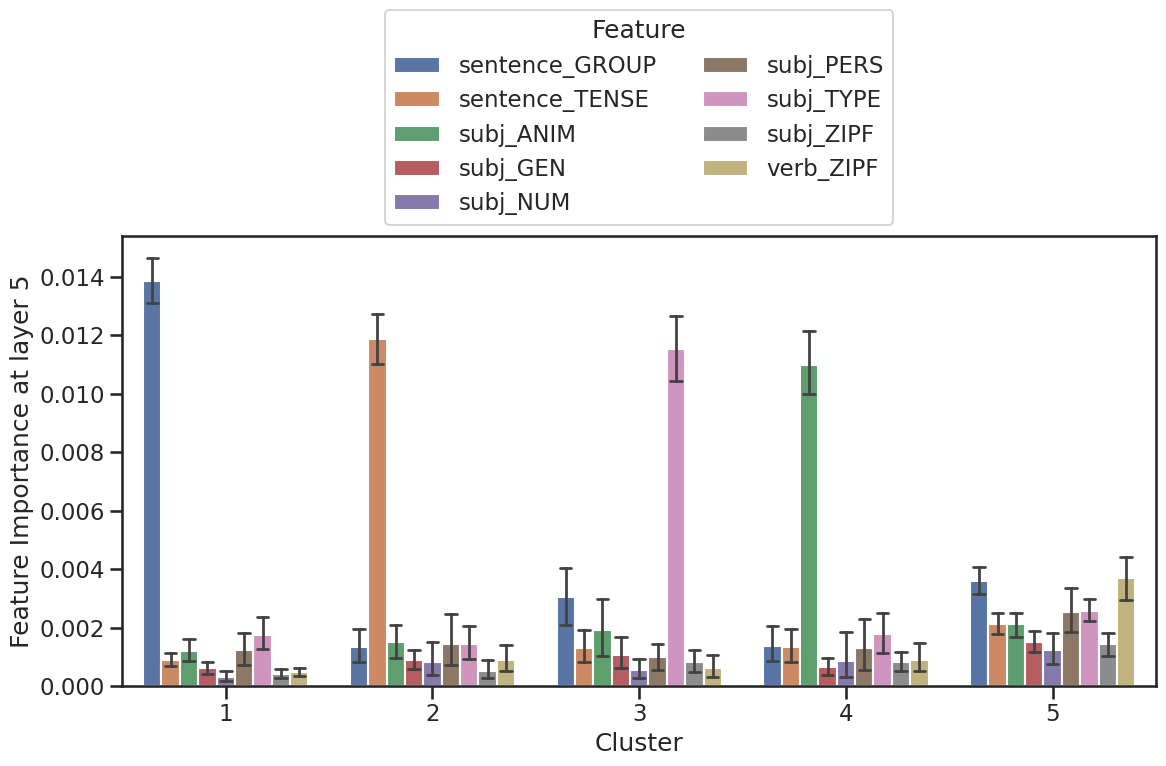

In [2]:
ax = pipeline.barplot_clusters()

Visualize the distribution of $R^2$ performance. To be complete this plot requires `compute_univariate_feature_importance` and `compute_feature_importance` to be run for all layers.

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

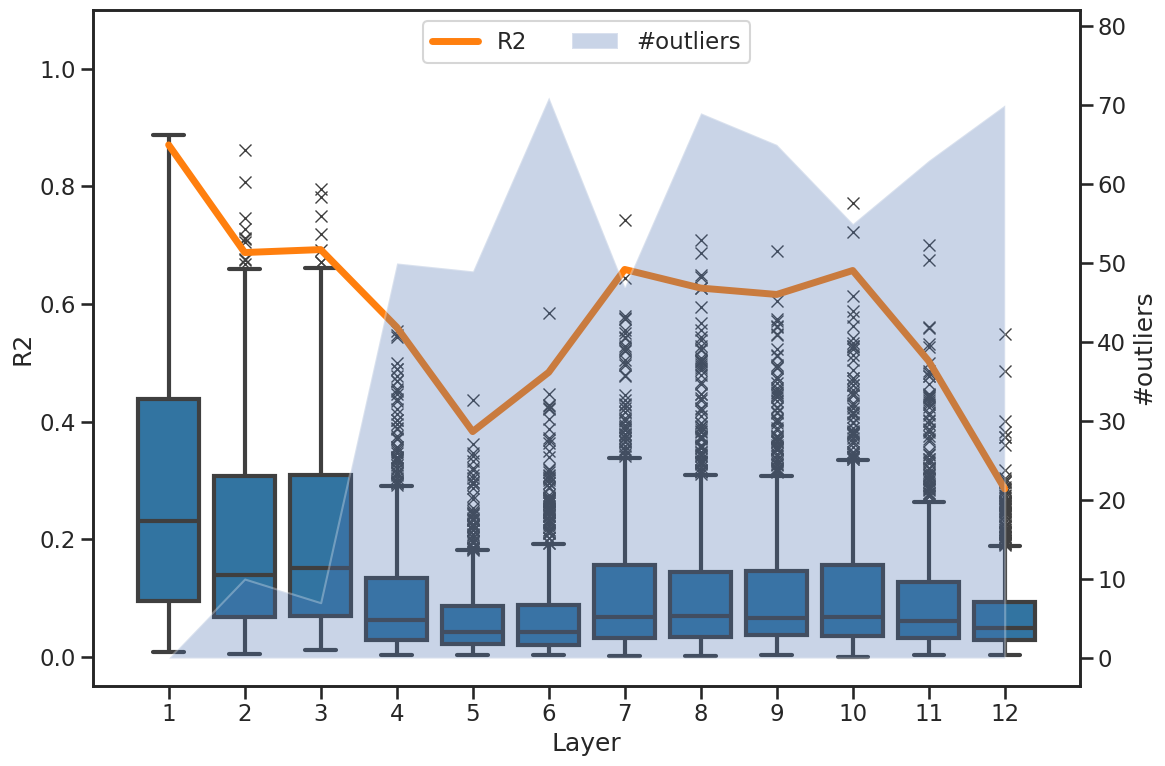

In [3]:
pipeline.top_units_rank = "R2"
ax = pipeline.plot_distrib_univariate()
pipeline.top_units_rank = None

## Top k multivariate

For a given layer, once the univariate Feature Importance has been computed for all the units (with `compute_univariate_feature_importance`), one can order those units based on the obtained performance (e.g. $R^2$ performance or Feature Importance for a given feature) and compute the multivariate Feature Importance only on the best performance units.
- `top_units_rank` defines the measure used to order the units (e.g. "R2" or a feature in the dataset)
- `top_units` defines the number of top performance units to consider
Again with `bert-base-uncased`, `top_units` can take values from 1 to 768 but computing the Feature Importance for all of them is not necessary.

In [ ]:
pipeline.layer = 5
pipeline.top_units_rank = "R2"
# create an array of top_units values exponentially increasing
top_units_array = np.exp(np.linspace(1, np.log(768), 25)).astype(int)
for top_units in tqdm(top_units_array):
    pipeline.top_units = top_units
    pipeline.compute_feature_importance()
pipeline.top_units = None

One can then visualize the evolution of the measure defined by `{top_units_rank}` when `{top_units}` increases using `plot_top_k`. The optimal measure`{top_units_rank}*` and the corresponding dimensionality `d*` are more accurate when `compute_feature_importance` has been called with more values of `{top_units}`.

  0%|          | 0/300 [00:00<?, ?it/s]

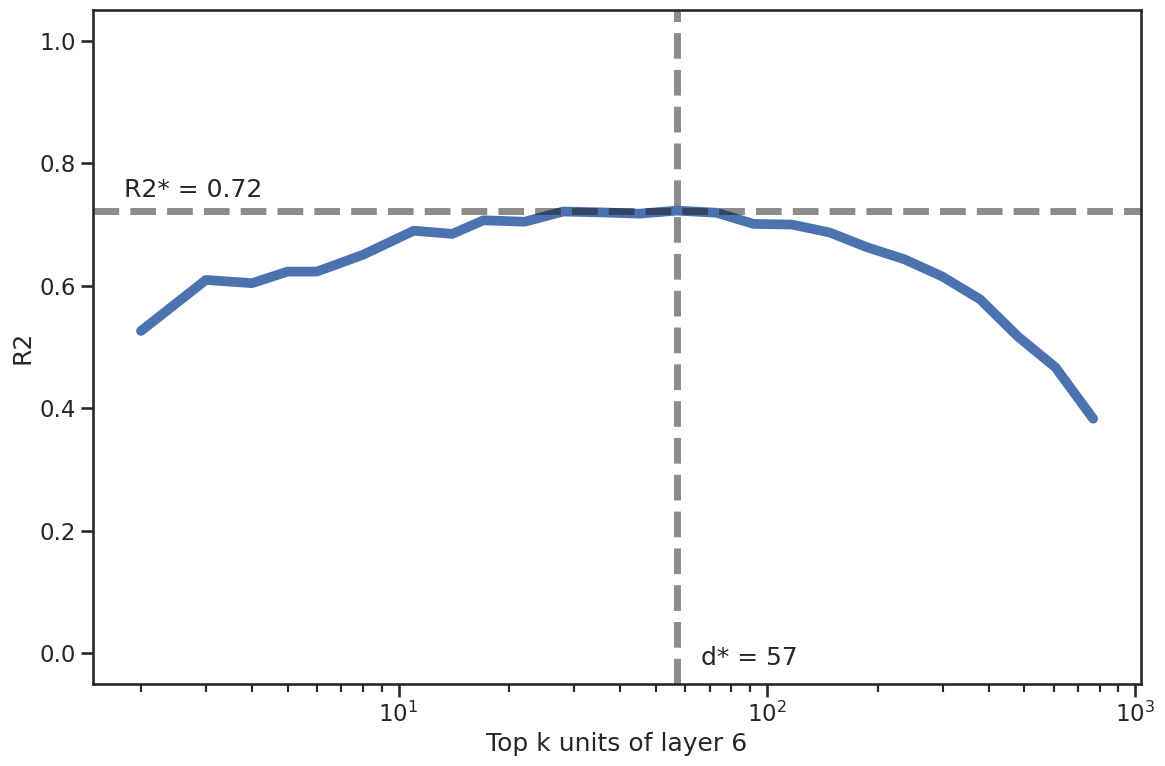

In [5]:
pipeline.top_units_rank = "R2"
ax = pipeline.plot_top_k(log_x=True)

With `optimal` as True, `plot_distrib_univariate` will also display the optimal top k measure defined by `{top_units_rank}` for each layer. It requires `compute_feature_importance` with `{top_units_rank}` and `{top_units}` to be run for at least 2 layers for something to appear.

In [ ]:
pipeline.layer = 6
pipeline.top_units_rank = "R2"
pipeline.compute_univariate_feature_importance()
for top_units in tqdm(top_units_array):
    pipeline.top_units = top_units
    pipeline.compute_feature_importance()
pipeline.top_units = None

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

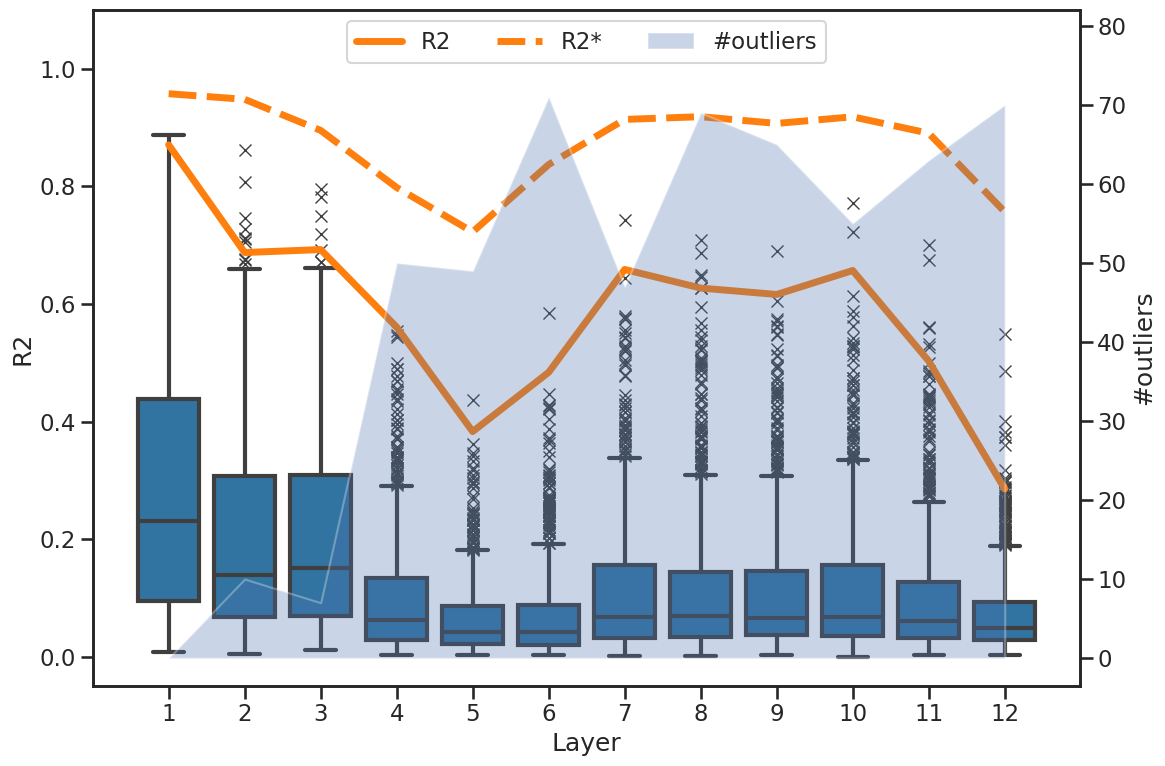

In [7]:
pipeline.top_units_rank = "R2"
ax = pipeline.plot_distrib_univariate(optimal=True)

## Misc

The results can be loaded using the method `get_results` which loads the corresponding results for all layers (and all seed/step). With a non-negative verbose level the number of files found is displayed.

In [ ]:
pipeline.verbose = 1
# Multivariate Feature Importance
df = pipeline.get_results(method="multivariate")
# Decoding baseline
df_decoding = pipeline.get_results(method="decoding")
# Univariate Feature Importance
df_univariate = pipeline.get_results(method="univariate")
# Top k mulativariate Feature Importance for R2
pipeline.top_units_rank = "R2"
df_top_k = pipeline.get_results(method="multivariate")

You can define a `rename` dictionnary which is used to rename almost everything for plotting.

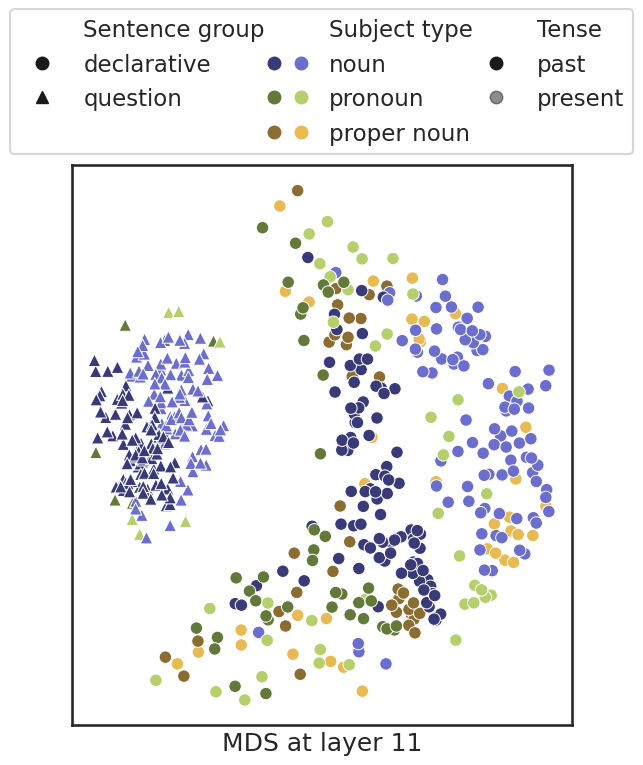

In [9]:
pipeline.rename = {
    "sentence_GROUP": "Sentence group",
    "subj_TYPE": "Subject type",
    "sentence_TENSE": "Tense",
    "sv": "declarative",
    "N": "noun",
    "PRO": "pronoun",
    "PropN": "proper noun",
    "pres": "present"
}
pipeline.layer = 11
ax = pipeline.plot_mds(hierarchy=["Sentence group", "Subject type", "Tense"])